<a href="https://colab.research.google.com/github/priya220405/HTMLActorPage/blob/main/solar_power_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Load dataset
df = pd.read_csv("/content/Merged_Generation_Data (1).csv")

In [5]:
# Convert date-time to features
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S',  errors='coerce')
df.dropna(subset=['DATE_TIME'], inplace=True)
df['HOUR'] = df['DATE_TIME'].dt.hour
df['DAY'] = df['DATE_TIME'].dt.day
df['MONTH'] = df['DATE_TIME'].dt.month
df['WEEKDAY'] = df['DATE_TIME'].dt.weekday
df['IS_WEEKEND'] = df['WEEKDAY'].isin([5, 6]).astype(int)

In [6]:
# Select features and target
features = ['DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'HOUR', 'DAY', 'MONTH',  'WEEKDAY', 'IS_WEEKEND']
target = 'AC_POWER'
X = df[features]
y = df[target]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale features and target
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [10]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
joblib.dump(rf_model, "random_forest_model.pkl")


['random_forest_model.pkl']

In [11]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6,  random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_model.save_model("xgboost_model.json")

In [16]:
# Prepare LSTM input
X_train_seq = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
# Train LSTM
lstm_model = Sequential([
LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], 1)),
Dropout(0.2),
LSTM(50, return_sequences=False),
Dropout(0.2),
Dense(25),
Dense(1)
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train_seq, y_train_scaled, epochs=100, batch_size=32,  callbacks=[early_stop], verbose=1)
lstm_pred_scaled = lstm_model.predict(X_test_seq)
lstm_pred = y_scaler.inverse_transform(lstm_pred_scaled)
lstm_model.save('my_model.keras')

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1693/1693 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0220
Epoch 2/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0021
Epoch 3/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0014
Epoch 4/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 9.8823e-04
Epoch 5/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 7.8562e-04
Epoch 6/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 7.1923e-04
Epoch 7/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 6.5000e-04
Epoch 8/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 5.9759e-04
Epoch 9/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 5.8966e-04
Epoch 10/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 5.2622e-04
Epoch 11/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 5.2165e-04
Epoch 12/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 5.0015e-04
Epoch 13/100
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 4.9438e-04
Epoch 14/100
1693/1693 ━━━━━━━━━━━━━━━━━━━

In [18]:
# Replace NaN predictions
if np.isnan(lstm_pred).any():
    print("⚠️ LSTM model produced NaN values. Replacing with zeros.")
    lstm_pred = np.nan_to_num(lstm_pred)

# Ensemble prediction (weighted)
w_rf, w_xgb, w_lstm = 0.2, 0.3, 0.5
ensemble_pred = (w_rf * rf_pred) + (w_xgb * xgb_pred) + (w_lstm * lstm_pred.flatten())
def evaluate_model(y_true, y_pred, model_name):
    if np.isnan(y_pred).any():
        print(f"⚠️ {model_name} has NaN predictions. Skipping evaluation.")
        return
    print(f"{model_name} Performance:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"R^2 Score: {r2_score(y_true, y_pred)}\n")
evaluate_model(y_test, ensemble_pred, "Solar XLR Model")

Solar XLR Model Performance:
MAE: 2.6795486950500695
MSE: 9.846784052484518
RMSE: 3.1379585804284473
R^2 Score: 0.9999244496001338



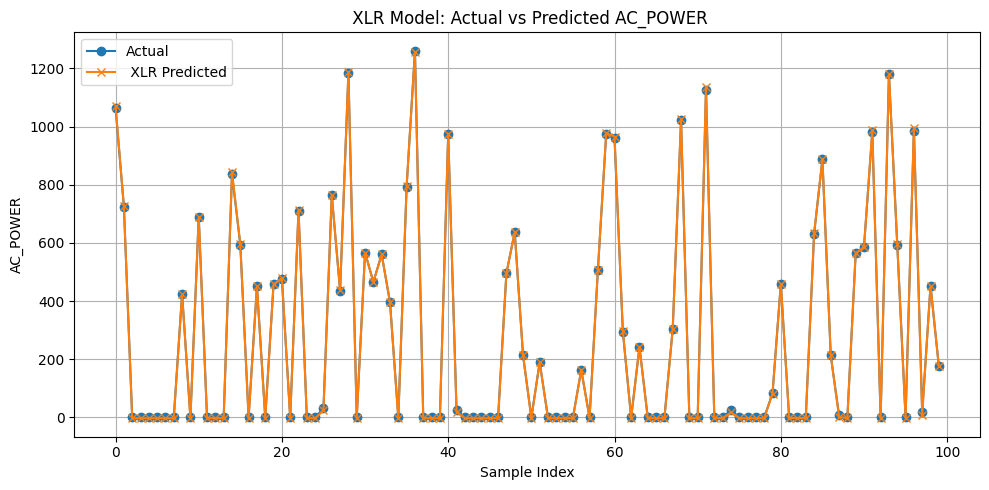

In [19]:
# Visualization: Actual vs XLR Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(ensemble_pred[:100], label=' XLR Predicted', marker='x')
plt.title(' XLR Model: Actual vs Predicted AC_POWER')
plt.xlabel('Sample Index')
plt.ylabel('AC_POWER')
27
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

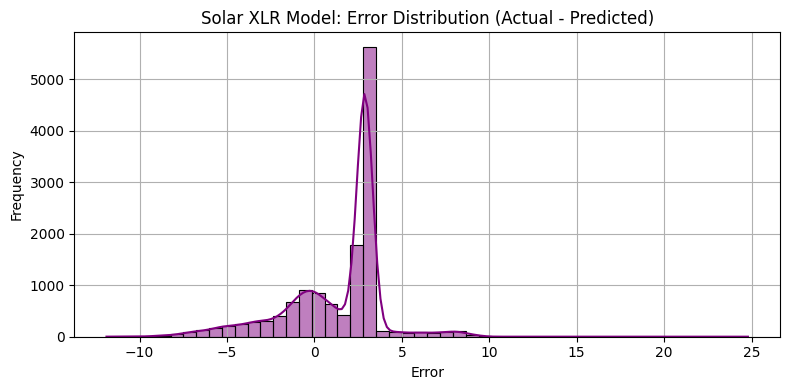

✅ XLR model evaluated and visualized successfully!


In [27]:
# Visualization: Error Distribution
errors = y_test.values - ensemble_pred
plt.figure(figsize=(8, 4))
sns.histplot(errors, bins=50, kde=True, color='purple')
plt.title('Solar XLR Model: Error Distribution (Actual - Predicted)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
print("✅ XLR model evaluated and visualized successfully!")